Using LSTMs to Predict the Output of Chemical Simulation under Uncertainty

In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import norm
from tqdm import tqdm
from base import TrainingConfig, BaseModel, CNNConfig, LSTMConfig
from models import *
from Bioprocess_Sim import *
from CSTR_Sim import *
from utils import *
from tqdm.notebook import tqdm
np.random.seed(42)

#### Create the Simulation Environment - for a CSTR

3 State Variables:
$$
C_A, \, T, \, \text{Concentration of A, Temperature and Setpoint}, C_{As}
$$

2 Manipulated Variables:
$$
T_i, \, C_{Af} \, \text{Inlet Temperature and Feed Concentration}
$$

Disturbance: 
$$
T_C, \text{ - coolant temperature}
$$

The Simulation randomly generates actions, setpoints and disturbances across the length of the simulation, with the aim of the data driven model being to learn the relationships between variables to predict the temporal value of the state variables (exc setpoint) within a confidence interval

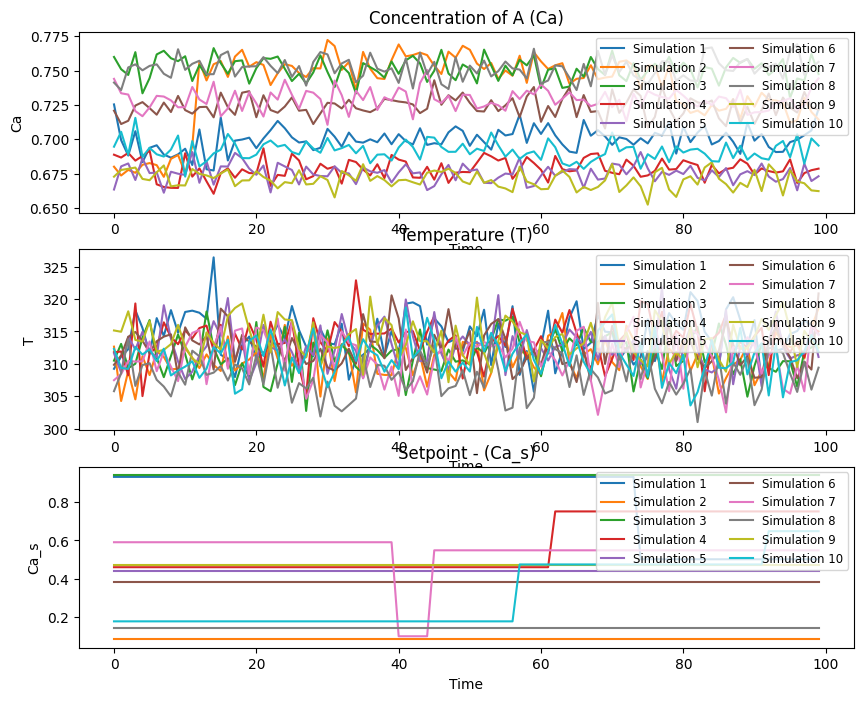

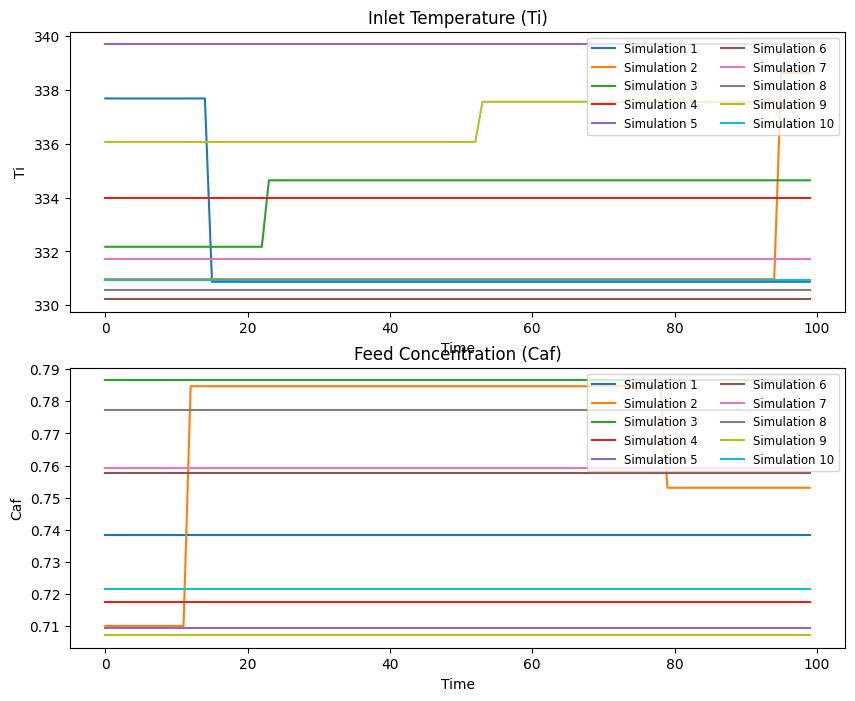

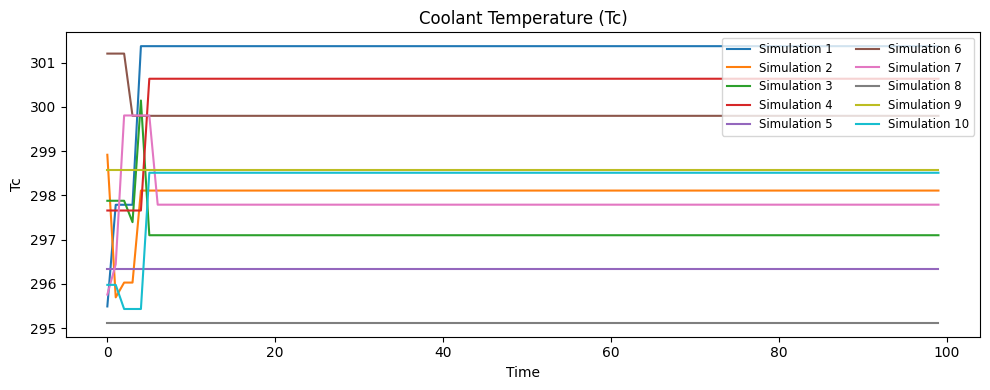

In [13]:
CSTR_Config = SimulationConfig(n_simulations=10, T = 101, tsim = 500) # Simulate the CSTR 10 times, with 5000 timesteps over 1000 second period

simulator = CSTRSimulator(CSTR_Config)
simulation_results = simulator.run_multiple_simulations()

# Plot the output of the Simulation
simulator.plot_results(simulation_results)

Then process the simulation output into data to be fed into the data driven model. First define a training configuration.

The data is processed into sequences with a lookback window and a prediction horizon of shape (time_step, lookback_window, no_features).

The data is then scaled using a MinMaxScaler, and split into a sequential train test set with the first 80% of the datapoints being included in the train set.


In [14]:
converter = CSTRConverter()
features, targets = converter.convert(simulation_results)

# Define a preliminary training configuration for the model
# Data processing uses an initial lookback region of 5 timesteps to predict 1 in the future 
# with an 80% train test split and a batch size of 4
training_config = TrainingConfig(
    batch_size = 4,
    num_epochs = 50,
    learning_rate = 0.001,
    time_step = 5,
    horizon = 1,
    weight_decay = 0.01,
    factor = 0.8,
    patience = 10,
    delta = 0.1,
    train_test_split = 0.8,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
)

data_processor = DataProcessor(training_config)
(train_loader, test_loader, X_train, X_test, y_train, y_test) = data_processor.prepare_data(features, targets)

Can then train an initial model, in this example use a unidirectional point prediction LSTM, defining the configuration for the model.

In [15]:
LSTM_Config = LSTMConfig(
    hidden_dim = 64,
    num_layers=2,
    dropout = 0.2,
    bidirectional=False,
)

quantiles = [0.25, 0.5, 0.75]

model = StandardLSTM(
    config = LSTM_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
)

# Train the model
criterion = nn.MSELoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

Epoch [10/50], Train Loss: 0.0410, Test Loss: 0.0416, Avg Loss: 0.0413
Epoch [20/50], Train Loss: 0.0416, Test Loss: 0.0418, Avg Loss: 0.0417
Epoch [30/50], Train Loss: 0.0407, Test Loss: 0.0423, Avg Loss: 0.0415
Epoch [40/50], Train Loss: 0.0418, Test Loss: 0.0423, Avg Loss: 0.0420
Epoch [50/50], Train Loss: 0.0408, Test Loss: 0.0415, Avg Loss: 0.0412


Evaluate the model and inverse transform the data to plot and visualise the model predictions against the ground truth.

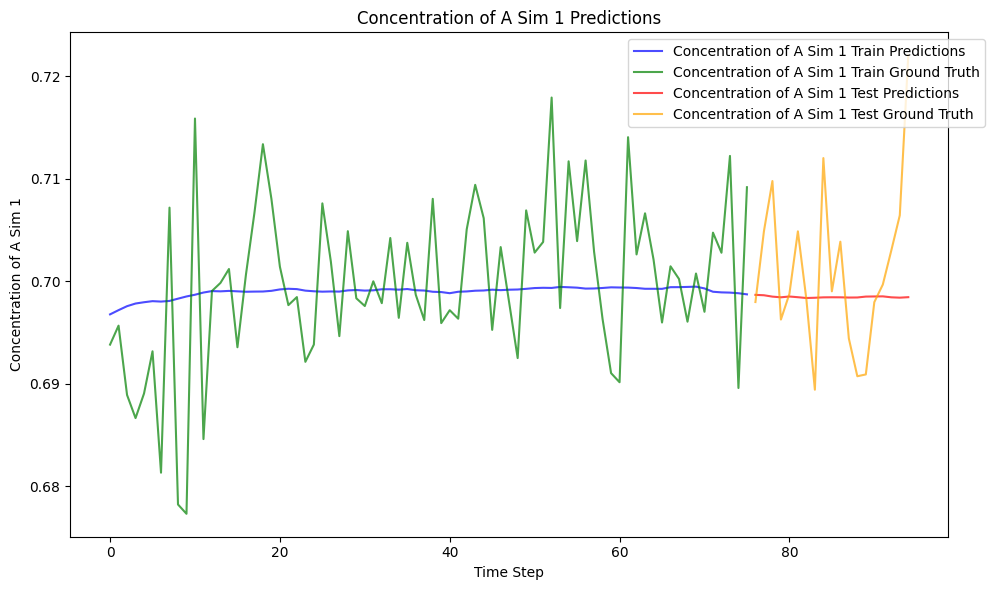

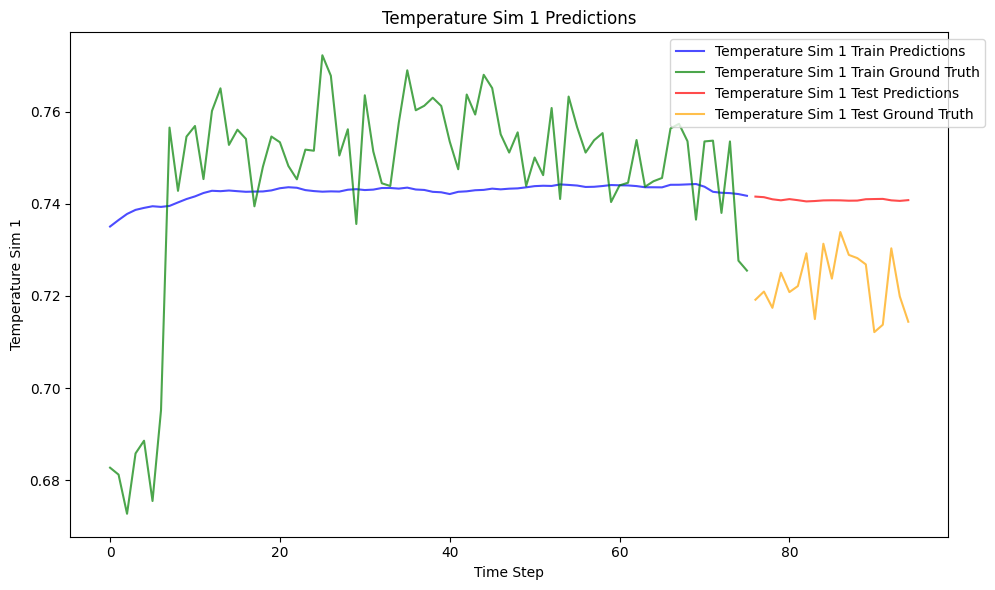

In [16]:
# Find the model predictions
model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(training_config.device)).cpu().numpy()
    test_pred = model(X_test.to(training_config.device)).cpu().numpy()

# Transform the predictions back to the original
scaler = data_processor.target_scaler
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Invert the ground truth data
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)


# Plot the results of the model
feature_names = ['Concentration of A', 'Temperature']
visualiser = Visualizer()
# For simplicity we will plot the first simulation
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=1)
    

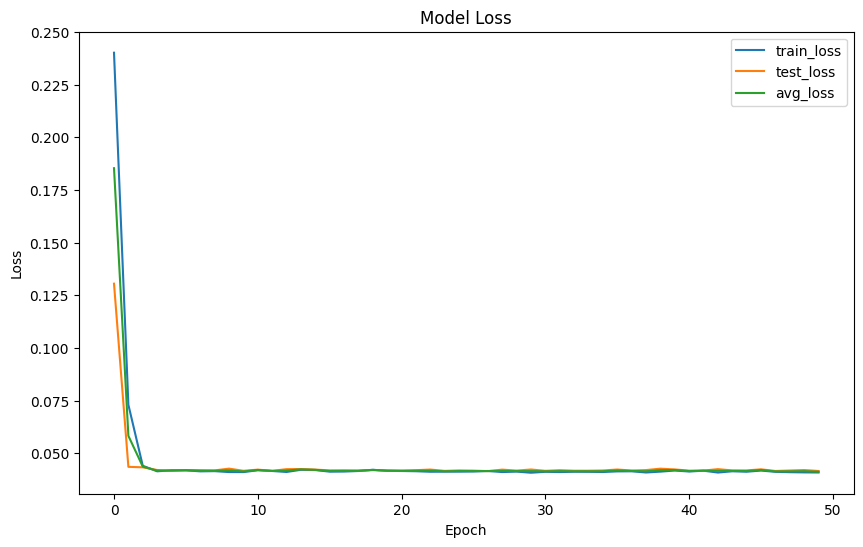

In [17]:
# Plot the loss of the model
visualiser.plot_loss(history)

Can use Bayesian Optimisation to find the best hyperparameters for the model

In [ ]:
# First set the bounds for LSTM Model
LSTM_ConfigBounds = {
        'batch_size': (2, 50) if isinstance(simulator, CSTRSimulator) else (2, 10),
        'num_epochs': (50, 200),
        'learning_rate': (0.0001, 0.1),
        'time_step': (2, 50) if isinstance(simulator, CSTRSimulator) else (2, 10),
        'horizon': (1, 10),
        'weight_decay': (1e-6, 0.1),
        'factor': (0.1, 0.99),
        'patience': (5, 100),
        'delta': (1e-6, 0.1),   
        
        # LSTM specific bounds
        'hidden_dim': (32, 256),
        'num_layers': (1, 15),
        'dropout': (0.1, 0.9),
        'bidirectional': (0, 1),
        'use_batch_norm': (0, 1),
    
}

# Call the optimiser
optimiser = ModelOptimisation(model_class=StandardLSTM, sim_config=CSTR_Config,
                              train_config=training_config, model_config=LSTM_Config,
                              config_bounds=LSTM_ConfigBounds, simulator=CSTRSimulator,
                              converter=CSTRConverter, data_processor=DataProcessor,
                              trainer_class=ModelTrainer, iters=20)

best_params, best_loss = optimiser.optimise()
# The best performing model is saved automatically by the optimiser and can be loaded
cp = torch.load('best_model.pth')
model = StandardLSTM(cp['model_config'],
                     input_dim=X_train.shape[2],
                     output_dim=y_train.shape[1],
                     )
model.load_state_dict(cp['model_state_dict'])

Epoch [10/195], Train Loss: 0.0505, Test Loss: 0.0561, Avg Loss: 0.0533
Epoch [20/195], Train Loss: 0.0535, Test Loss: 0.0549, Avg Loss: 0.0542
Epoch [30/195], Train Loss: 0.0418, Test Loss: 0.0452, Avg Loss: 0.0435
Epoch [40/195], Train Loss: 0.0437, Test Loss: 0.0441, Avg Loss: 0.0439
Epoch [50/195], Train Loss: 0.0427, Test Loss: 0.0455, Avg Loss: 0.0441
Epoch [60/195], Train Loss: 0.0435, Test Loss: 0.0464, Avg Loss: 0.0449
Epoch [70/195], Train Loss: 0.0467, Test Loss: 0.0471, Avg Loss: 0.0469
Epoch [80/195], Train Loss: 0.0460, Test Loss: 0.0468, Avg Loss: 0.0464
Epoch [90/195], Train Loss: 0.0462, Test Loss: 0.0466, Avg Loss: 0.0464
Epoch [100/195], Train Loss: 0.0443, Test Loss: 0.0442, Avg Loss: 0.0443
Epoch [110/195], Train Loss: 0.0475, Test Loss: 0.0456, Avg Loss: 0.0465
Epoch [120/195], Train Loss: 0.0447, Test Loss: 0.0392, Avg Loss: 0.0419
Epoch [130/195], Train Loss: 0.0467, Test Loss: 0.0463, Avg Loss: 0.0465
Epoch [140/195], Train Loss: 0.0437, Test Loss: 0.0469, Avg 

After optimising the model, load the data

In [ ]:
train_pred = model(X_train.to(training_config.device)).cpu().numpy()
test_pred = model(X_test.to(training_config.device)).cpu().numpy()

# Transform the predictions back to the original
train_pred, test_pred = scaler.inverse_transform(train_pred), scaler.inverse_transform(test_pred)
 
# Plot the optimised predictions of the model
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=1)

Can also use a second simulation, a Photoproduction Bioprocess Reactor.

This has state variables:
$C_x$ , biomass concentration in g/L

$C_N$ , nitrate concentration in mg/L

$C_{qc}$ , phycocyanin concentration in mg/L

The control variables are:
$I$, light intensity in $\mu  mol  m^{-2}  s^{-1}$

$F_N$, nitrate flow rate in $ mg. L^{-1} h{-1} $

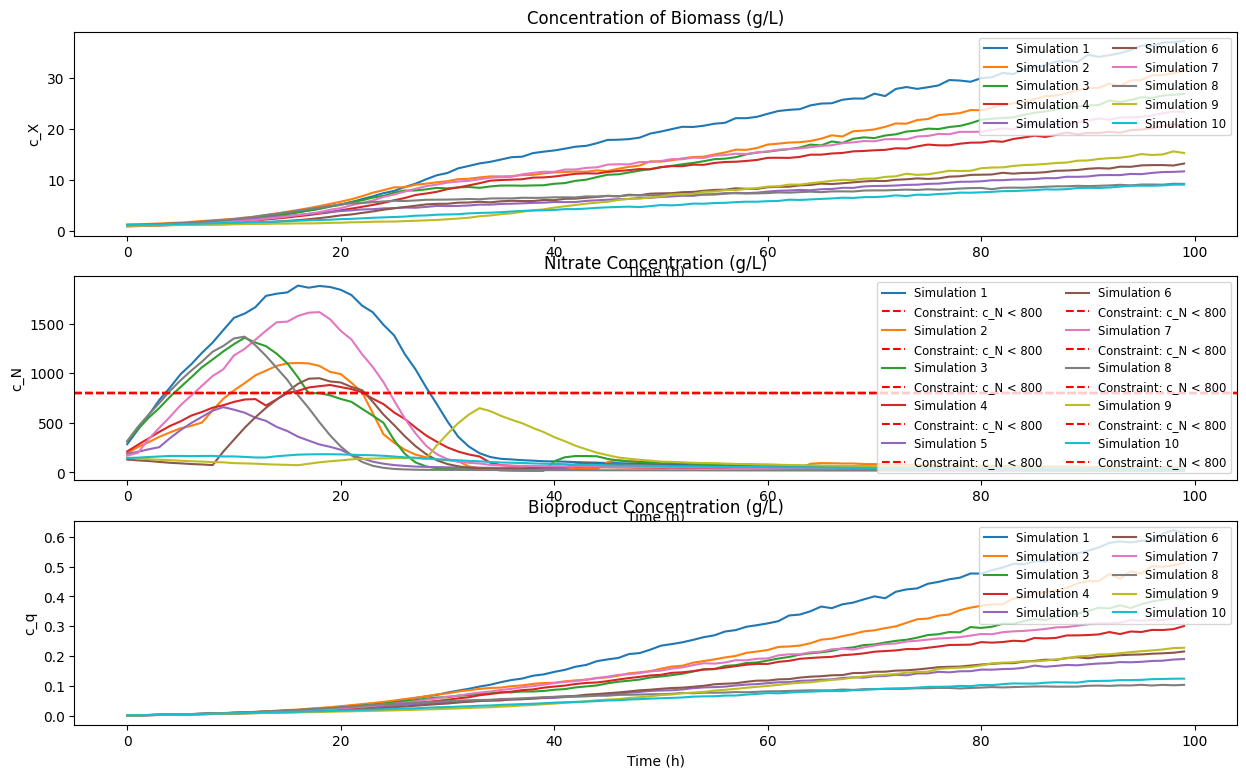

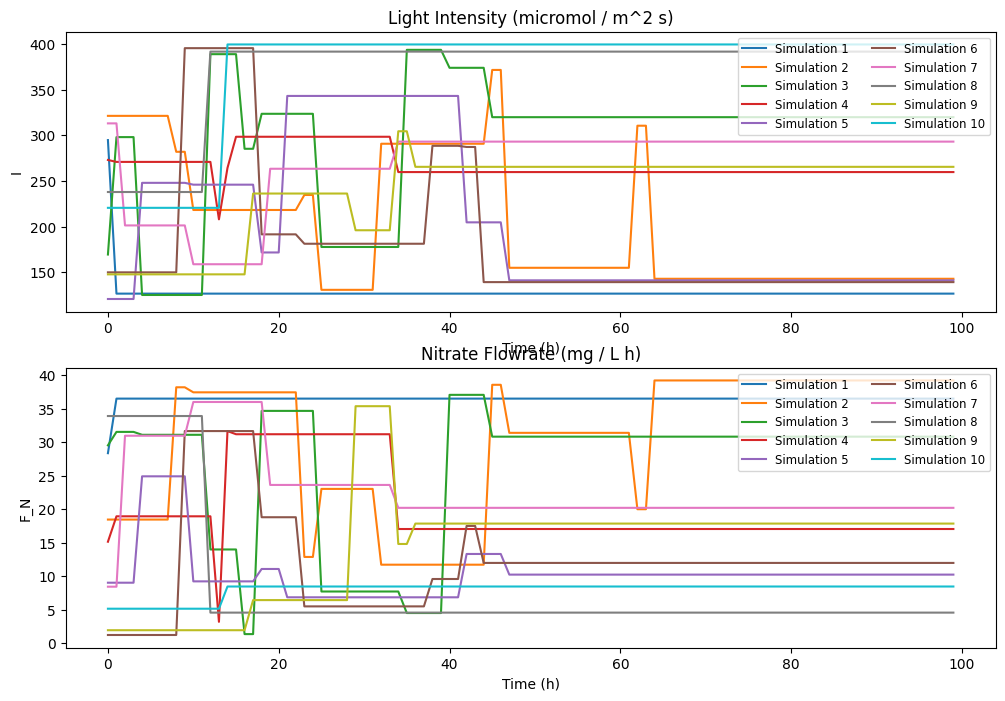

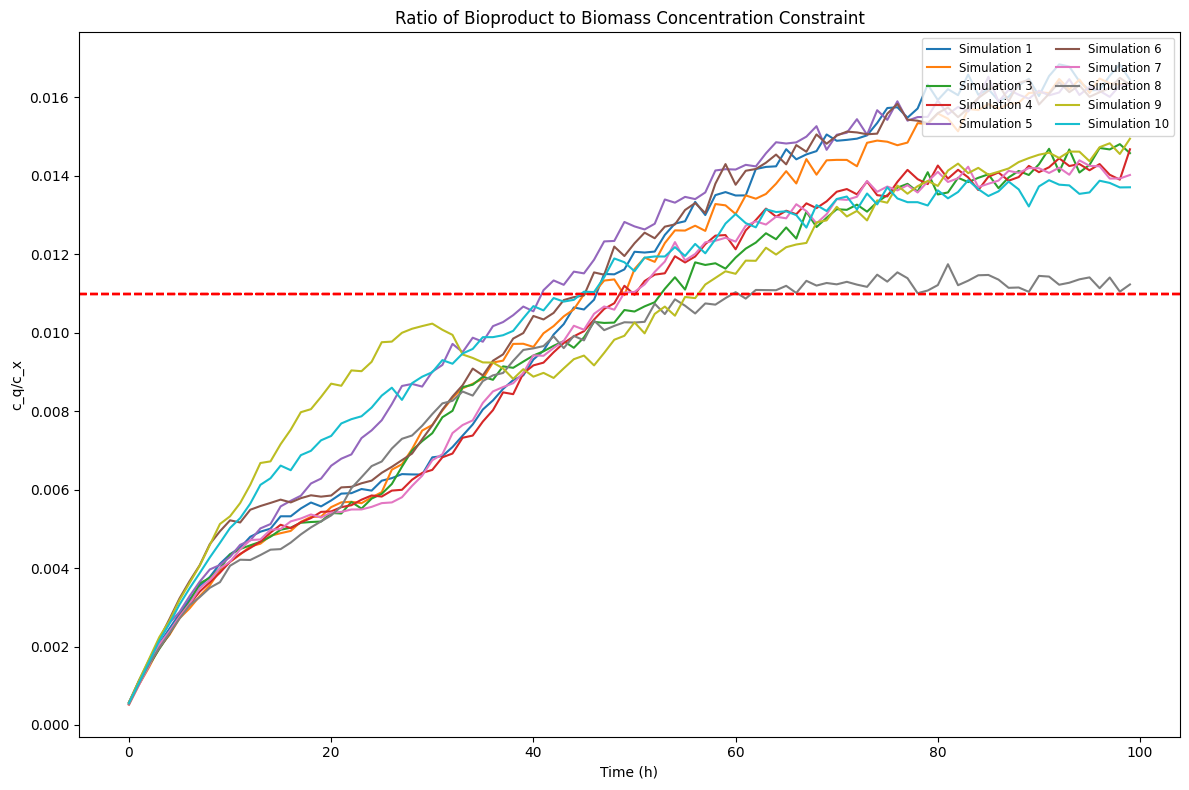

In [ ]:
Bioprocess_Config = SimulationConfig(n_simulations=10, T = 101, tsim = 500) # Simulate the CSTR 10 times, with 5000 timesteps over 1000 second period

simulator = BioProcessSimulator(Bioprocess_Config)
simulation_results = simulator.run_multiple_simulations()

# Plot the output of the Simulation
simulator.plot_results(simulation_results)

In [ ]:
converter = BioprocessConverter()
features, targets = converter.convert(simulation_results)

# Define a preliminary training configuration for the model
# Data processing uses an initial lookback region of 5 timesteps to predict 1 in the future 
# with an 80% train test split and a batch size of 4
training_config = TrainingConfig(
    batch_size = 4,
    num_epochs = 50,
    learning_rate = 0.001,
    time_step = 5,
    horizon = 1,
    weight_decay = 0.01,
    factor = 0.8,
    patience = 10,
    delta = 0.1,
    train_test_split = 0.8,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
)

data_processor = DataProcessor(training_config)
(train_loader, test_loader, X_train, X_test, y_train, y_test) = data_processor.prepare_data(features, targets)

Epoch [10/74], Train Loss: 0.1549, Test Loss: 0.1307, Avg Loss: 0.1428
Epoch [20/74], Train Loss: 0.0507, Test Loss: 0.0483, Avg Loss: 0.0495
Epoch [30/74], Train Loss: 0.0464, Test Loss: 0.0455, Avg Loss: 0.0459
Epoch [40/74], Train Loss: 0.0444, Test Loss: 0.0444, Avg Loss: 0.0444
Epoch [50/74], Train Loss: 0.0439, Test Loss: 0.0437, Avg Loss: 0.0438
Epoch [60/74], Train Loss: 0.0431, Test Loss: 0.0431, Avg Loss: 0.0431
Epoch [70/74], Train Loss: 0.0432, Test Loss: 0.0429, Avg Loss: 0.0430


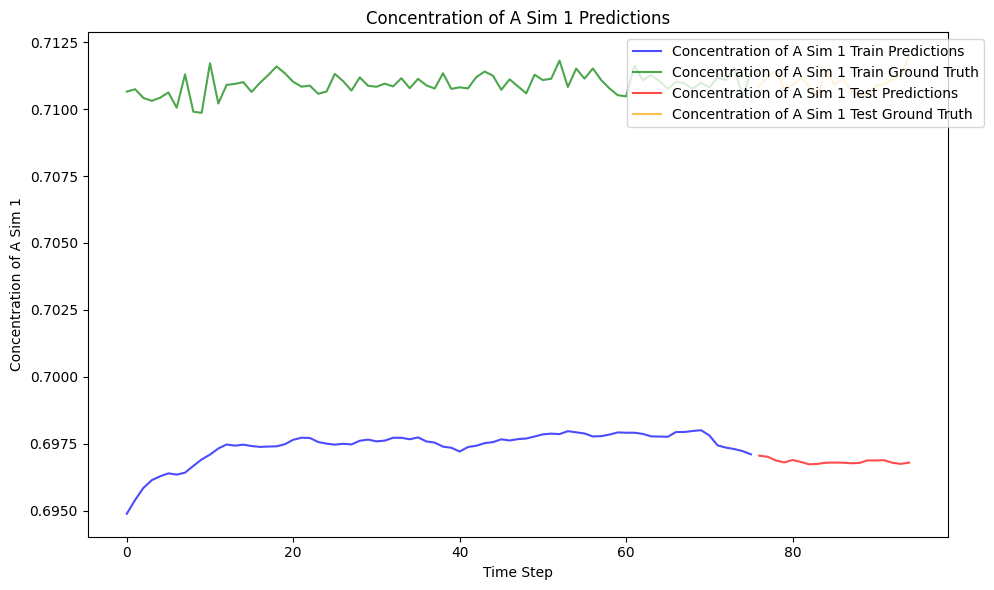

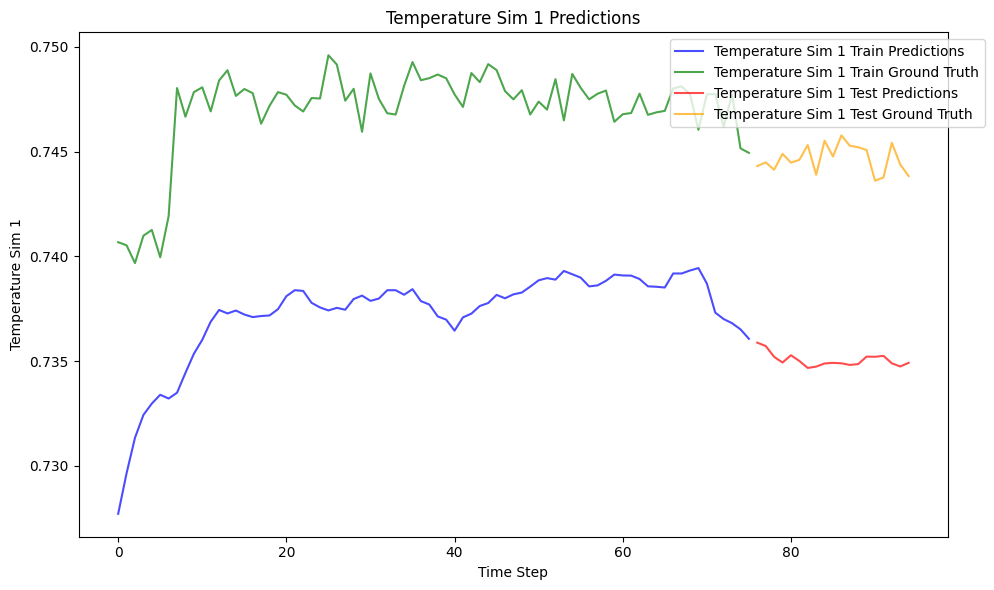

In [ ]:
LSTM_Config = LSTMConfig(
    hidden_dim = 64,
    num_layers=2,
    dropout = 0.2,
    bidirectional=False,
)

quantiles = [0.25, 0.5, 0.75]

model = StandardLSTM(
    config = LSTM_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
)

# Train the model
criterion = nn.MSELoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

# Find the model predictions
model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(training_config.device)).cpu().numpy()
    test_pred = model(X_test.to(training_config.device)).cpu().numpy()

# Transform the predictions back to the original
scaler = data_processor.target_scaler
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Invert the ground truth data
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)


# Plot the results of the model
feature_names = ['Concentration of A', 'Temperature']
visualiser = Visualizer()
# For simplicity we will plot the first simulation
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=1)